# Generate random observation data for 7DT and KMTNet
- Gregory S.H. Paek
- 22.09.29
- medium-band, ugri, BVRI


In [1]:
import glob, os
from astropy.io import ascii
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, vstack
import matplotlib as mpl
from astropy import units as u
import speclite.filters
import time
import multiprocessing
from itertools import repeat

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 20
plt.rcParams['savefig.dpi'] = 200
plt.rc('font', family='serif')

## Useful functions

In [3]:
from helper import makeSpecColors
from helper import convert_flam2fnu
from helper import get_wollaeger
from helper import convert_app2abs
from helper import convert_abs2app
kncbtbl = get_wollaeger()
from helper import get_bandwidth_table
bdwtbl = get_bandwidth_table()
#	speclite
from helper import get_speclite_med
meds = get_speclite_med()
mlam = meds.effective_wavelengths
mbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Med']*u.Angstrom
from helper import get_speclite_sdss
sdss = get_speclite_sdss()
slam = sdss.effective_wavelengths
sbdw = bdwtbl['bandwidth'][bdwtbl['group']=='SDSS']*u.Angstrom
from helper import get_speclite_jc
jc = get_speclite_jc()
jclam = jc.effective_wavelengths
jcbdw = bdwtbl['bandwidth'][bdwtbl['group']=='Johnson Cousin']*u.Angstrom
#
from helper import get_7dt_depth
dptbl = get_7dt_depth(exptime=180)

In [4]:
magoffset = -4.3

- Synphot Table

In [5]:
knsp = '../3.table/kn_sim_cube_synphot/Run_TS_dyn_all_lanth_wind2_all_md0.1_vd0.3_mw0.1_vw0.3_angle0_synphot_med.ecsv'
intbl = ascii.read(knsp)
intbl[10:25]

t,m400,m425,m450,m475,m500,m525,m550,m575,m600,m625,m650,m675,m700,m725,m750,m775,m800,m825,m850,m875
d,mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB),mag(AB)
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
0.297,-14.019,-13.942,-13.855,-13.756,-13.654,-13.553,-13.459,-13.412,-13.405,-13.392,-13.375,-13.343,-13.295,-13.244,-13.146,-13.122,-13.076,-13.016,-12.924,-12.854
0.324,-14.024,-13.950,-13.877,-13.782,-13.689,-13.599,-13.523,-13.468,-13.444,-13.435,-13.399,-13.386,-13.331,-13.283,-13.210,-13.148,-13.121,-13.071,-13.008,-12.939
0.354,-14.008,-13.938,-13.878,-13.793,-13.702,-13.638,-13.568,-13.511,-13.480,-13.456,-13.431,-13.413,-13.370,-13.326,-13.267,-13.198,-13.164,-13.114,-13.042,-13.021
0.386,-13.963,-13.890,-13.856,-13.794,-13.702,-13.652,-13.611,-13.551,-13.509,-13.475,-13.451,-13.430,-13.399,-13.346,-13.292,-13.242,-13.200,-13.160,-13.097,-13.058
0.42,-13.874,-13.807,-13.804,-13.785,-13.703,-13.650,-13.633,-13.600,-13.558,-13.519,-13.479,-13.445,-13.424,-13.360,-13.316,-13.282,-13.228,-13.190,-13.158,-13.094
0.459,-13.698,-13.665,-13.691,-13.740,-13.695,-13.646,-13.643,-13.637,-13.600,-13.566,-13.521,-13.478,-13.443,-13.399,-13.353,-13.308,-13.262,-13.236,-13.201,-13.167
0.5,-13.414,-13.447,-13.507,-13.639,-13.658,-13.623,-13.637,-13.661,-13.646,-13.619,-13.576,-13.529,-13.488,-13.439,-13.397,-13.344,-13.313,-13.290,-13.257,-13.235
0.545,-13.037,-13.138,-13.255,-13.451,-13.559,-13.561,-13.588,-13.661,-13.682,-13.676,-13.641,-13.594,-13.548,-13.498,-13.465,-13.407,-13.374,-13.347,-13.319,-13.299


In [6]:
def extract_param_kn_sim_cube(knsp):
	part = os.path.basename(knsp).split('_')

	if part[1] == 'TP':
		dshape = 'toroidal'
	elif part[1] == 'TS':
		dshape = 'spherical'
	else:
		dshape = ''

	#	Latitude
	if part[5] == 'wind1':
		lat = 'Axial'
	elif part[5] == 'wind2':
		lat = 'Edge'
	else:
		lat = ''

	#	Ejecta mass for low-Ye [solar mass]
	md = float(part[7].replace('md', ''))

	#	Ejecta velocity for low-Ye [N*c]
	vd = float(part[8].replace('vd', ''))

	#	Ejecta mass for high-Ye [solar mass]
	mw = float(part[9].replace('mw', ''))

	#	Ejecta velocity for high-Ye [N*c]
	vw = float(part[10].replace('vw', ''))

	#	Angle
	angle = float(part[11].replace('angle', ''))

	return dshape, lat, md, vd, mw, vw, angle

In [7]:
dshape, lat, md, vd, mw, vw, angle = extract_param_kn_sim_cube(knsp)
print(dshape, lat, md, vd, mw, vw, angle)

spherical Edge 0.1 0.3 0.1 0.3 0.0


- Depth Table

In [8]:
dptbl[:3]

index,name,center_wavelength,fwhm,min_wavelength,max_wavelength,noise_countrate,surface_brightness,5sigma_depth
,,Angstrom,Angstrom,Angstrom,Angstrom,electron / s,mag / arcsec2,mag
int64,str4,float64,float64,float64,float64,float64,float64,float64
0,m400,4000.0,250.0,3875.0,4125.0,0.1455,20.73,20.81
1,m425,4250.0,250.0,4125.0,4375.0,0.2042,20.85,20.93
2,m450,4500.0,250.0,4375.0,4625.0,0.2812,20.89,20.97


In [9]:
def calc_snr(m, ul, sigma=5):
	snr = sigma*10**((ul-m)/5)
	return snr

def convert_snr2magerr(snr):
	merr = 2.5*np.log10(1+1/snr)
	return merr

def calc_GaussianFraction(seeing, optfactor=0.6731, path_plot=None):
	import numpy as np
	import matplotlib.pyplot as plt
	from scipy.special import erf

	# seeing, optfactor= 1.5, 0.6731

	mu = 0.0
	# sigma = fwhm_seeing/2.355
	fwhm2sigma = seeing*2.355
	# optfactor = 0.6731
	sigma = fwhm2sigma*optfactor

	x = np.linspace(-8, 8, 1000)
	y = (1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp(-(x-mu)**2 / (2 * sigma**2))
	y_cum = 0.5 * (1 + erf((x - mu)/(np.sqrt(2 * sigma**2))))

	indx_aperture = np.where(
		(x>-sigma*optfactor) &
		(x<+sigma*optfactor)
	)
	xaper = x[indx_aperture]
	yaper = y[indx_aperture]

	frac = np.sum(yaper)/np.sum(y) 
	# print(np.sum(y), np.sum(yaper), frac)

	if path_plot != None:
		plt.plot(x, y, alpha=0.5, label=f'PDF of N(0, {sigma:1.3f})', lw=5)
		plt.plot(xaper, yaper, alpha=1.0, label=f'Aperture ({frac*1e2:.1f}%)', lw=5,)
		plt.xlabel('x', fontsize=20)
		plt.ylabel('f(x)', fontsize=20)
		plt.legend(loc='lower center', fontsize=14)
		# plt.show()
		plt.savefig(path_plot, overwrite=True)
	else:
		pass

	return frac

def add_noise(mu, sigma, nseed, n=10, path_plot=None):
	"""
	mu, sigma = 17.5, 0.1
	n = 10
	"""
	from scipy.stats import norm
	import numpy as np
	
	x = np.arange(mu-sigma*n, mu+sigma*n, sigma*1e-3)
	y = norm(mu, sigma).pdf(x)

	if path_plot != None:
		resultlist = []
		for i in range(10000):
			xobs = np.random.choice(x, p=y/np.sum(y))
			# print(xobs)
			resultlist.append(xobs)
		plt.axvspan(xmin=mu-sigma, xmax=mu+sigma, alpha=0.5, color='tomato',)
		plt.axvline(x=mu, ls='--', alpha=1.0, color='tomato', lw=3)
		plt.plot(x, y, lw=3, alpha=0.75, color='grey')
		plt.hist(resultlist, lw=3, alpha=0.75, color='k', histtype='step', density=True)
		plt.xlabel(r'$\rm m_{obs}$')
		plt.plot(x, y)
		plt.savefig(path_plot, overwrite=True)
	else:
		pass
	#	more complicated choice with the fixed random seed
	np.random.seed(int((nseed+1)+(mu*1e2)))
	return np.random.choice(x, p=y/np.sum(y))

Text(0.5, 0, '$\\rm m_{obs}$')

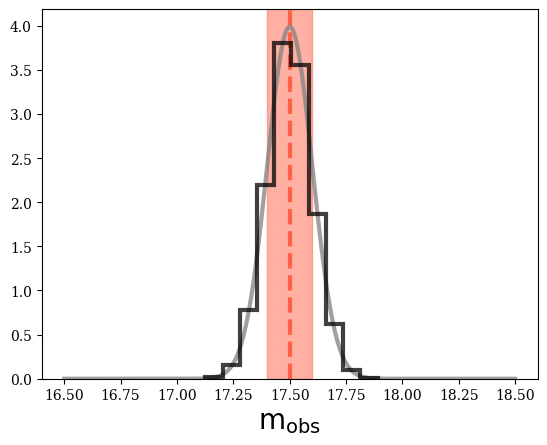

In [10]:
mu, sigma = 17.5, 0.1
n = 10

from scipy.stats import norm
import numpy as np

x = np.arange(mu-sigma*n, mu+sigma*n, sigma*1e-3)
y = norm(mu, sigma).pdf(x)

resultlist = []
for i in range(10000):
	xobs = np.random.choice(x, p=y/np.sum(y))
	# print(xobs)
	resultlist.append(xobs)
plt.axvspan(xmin=mu-sigma, xmax=mu+sigma, alpha=0.5, color='tomato',)
plt.axvline(x=mu, ls='--', alpha=1.0, color='tomato', lw=3)
plt.plot(x, y, lw=3, alpha=0.75, color='grey')
plt.hist(resultlist, lw=3, alpha=0.75, color='k', histtype='step', density=True)
rdval = np.random.choice(x, p=y/np.sum(y))
plt.xlabel(r'$\rm m_{obs}$')


In [11]:
aperfrac = calc_GaussianFraction(seeing=1.5, optfactor=0.6731, path_plot=None)

In [12]:
calc_snr(m=17, ul=20, sigma=5)*aperfrac

9.948786966171316

In [13]:
#	Setting
niteration = 10
d = 40*u.Mpc
aperfrac = calc_GaussianFraction(seeing=1.5, optfactor=0.6731, path_plot=None)
times = np.unique(intbl['t'])
mfilterlist = [filte for filte in intbl.keys() if filte != 't']

t0 = time.time()
tablelist = []
# for nseed in range(niteration):

# 	outbl = Table()
# 	# outbl.meta['distance'] = d
# 	outbl['seed'] = [nseed]*len(times)
# 	outbl['t'] = times

# 	for filte in mfilterlist:
# 		depth = dptbl['5sigma_depth'][dptbl['name']==filte].item()*u.ABmag
# 		# outbl.meta[f'depth_{filte}'] = depth

# 		outbl[f'magabs_{filte}'] = (intbl[filte]+magoffset)*u.ABmag
# 		outbl[f'magapp_{filte}'] = convert_abs2app(outbl[f'magabs_{filte}'], d.to(u.pc).value)*u.ABmag
# 		outbl[f'snr_{filte}'] = calc_snr(outbl[f'magapp_{filte}'], depth.value)*aperfrac
# 		outbl[f'magerr_{filte}'] = convert_snr2magerr(outbl[f'snr_{filte}'])*u.ABmag
# 		outbl[f'magobs_{filte}'] = [add_noise(mu=m, sigma=merr, nseed=nseed, n=10, path_plot=None) for m, merr in zip(outbl[f'magapp_{filte}'], outbl[f'magerr_{filte}'])]*u.ABmag
		
# 		outbl[f'fnu_{filte}'] = outbl[f'magapp_{filte}'].to(u.uJy)
# 		outbl[f'fnuobs_{filte}'] = outbl[f'magobs_{filte}'].to(u.uJy)
# 		outbl[f'fnuerr_{filte}'] = outbl[f'fnu_{filte}']/outbl[f'snr_{filte}']

# 		outbl[f'detection_{filte}'] = [True if m<=depth.value else False for m in outbl[f'magobs_{filte}']]

# 		outbl[f'magabs_{filte}'].format = '1.3f'
# 		outbl[f'magapp_{filte}'].format = '1.3f'
# 		outbl[f'magerr_{filte}'].format = '1.3f'
# 		outbl[f'magobs_{filte}'].format = '1.3f'
# 		outbl[f'fnu_{filte}'].format = '1.3f'
# 		outbl[f'fnuobs_{filte}'].format = '1.3f'
# 		outbl[f'fnuerr_{filte}'].format = '1.3f'
# 		outbl[f'snr_{filte}'].format = '1.3f'

# 	#	Table of results --> tabelist
# 	tablelist.append(outbl)

# comtbl = vstack(tablelist)
# comtbl.meta['name'] = os.path.basename(knsp)
# for filte in mfilterlist: comtbl.meta[f'depth_{filte}'] = dptbl['5sigma_depth'][dptbl['name']==filte].item()*u.ABmag
# comtbl.meta['distance'] = d
# comtbl.meta['dshape'] = dshape
# comtbl.meta['lat'] = lat
# comtbl.meta['md'] = md
# comtbl.meta['vd'] = vd
# comtbl.meta['mw'] = mw
# comtbl.meta['vw'] = vw
# comtbl.meta['angle'] = angle

# delt = time.time() - t0
# print(f"Time ({niteration} iter.) : {delt:1.3f} sec")
# print(f"Time/iteration  : {delt/niteration:1.3f} sec/iter.")

- Expected time

In [14]:
# ndelt = delt/niteration
# for nn in np.arange(0, 6+1, 1):
# 	print(f"10^{nn} iter. : {(ndelt*10**nn)/60:1.3f} min")

In [15]:
# comtbl[10:30]
# comtbl.meta

In [16]:
# t = times[0]
# # seeds = np.arange(0, 99+1, 1)
# seeds = np.arange(0, 9+1, 1)
# nseed = len(seeds)
# colors = makeSpecColors(nseed)

# for ii, nseed in enumerate(seeds):
# 	magobslist = [comtbl[key][(comtbl['t']==t) & (comtbl['seed']==nseed)].item() for key in comtbl.keys() if 'magobs' in key]
# 	magerrlist = [comtbl[key][(comtbl['t']==t) & (comtbl['seed']==nseed)].item() for key in comtbl.keys() if 'magerr' in key]
# 	if ii == 0:
# 		magapplist = [comtbl[key][(comtbl['t']==t) & (comtbl['seed']==nseed)].item() for key in comtbl.keys() if 'magapp' in key]
# 		plt.errorbar(mlam, magapplist, xerr=mbdw/2, yerr=magerrlist, marker='.', ms=10, capsize=3, elinewidth=2, c='red', label='Truth', ls='None', alpha=1.0)
# 	else:
# 		pass

# 	plt.errorbar(mlam, magobslist, xerr=mbdw/2, yerr=magerrlist, ls='None', alpha=0.05, c='grey',)
# 	# plt.errorbar(mlam, magobslist, xerr=mbdw/2, yerr=magerrlist, label=f'{nseed}th obs', ls='None', alpha=0.5, c=colors[ii])
# 	# plt.errorbar(mlam, magobslist, xerr=mbdw/2, yerr=magerrlist, label=f'{nseed}th obs', ls='None', alpha=0.05, c='dodgerblue')

# xl, xr = plt.xlim()
# yl, yu = plt.ylim()

# plt.errorbar(0, 0, xerr=0, yerr=0, ls='None', alpha=1.0, c='grey', label='Obs')

# plt.legend(loc='upper center', ncol=4, fontsize=14)
# plt.xlim([xl, xr])
# plt.ylim([yu, yl])
# plt.xlabel(r'Wavelength [$\rm \AA$]', fontsize=14)
# plt.ylabel('App. mag [AB]', fontsize=14)
# plt.title(f't={t:1.3f} days')

# Iteration

- Setting

In [17]:
path_result = "../5.result/kn_sim_cube_obs"
if ~os.path.exists(path_result): os.system(f"mkdir {path_result}")

mkdir: ../5.result/kn_sim_cube_obs: File exists


In [18]:
niteration = int(1e2)
d = 40*u.Mpc
aperfrac = calc_GaussianFraction(seeing=1.5, optfactor=0.6731, path_plot=None)

In [19]:
knsplist = sorted(glob.glob("../3.table/kn_sim_cube_synphot/Run_*_synphot_med.ecsv"))
knsplist[:5]

['../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle0_synphot_med.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle120_synphot_med.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle150_synphot_med.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle180_synphot_med.ecsv',
 '../3.table/kn_sim_cube_synphot/Run_TP_dyn_all_lanth_wind1_all_md0.001_vd0.05_mw0.001_vw0.05_angle30_synphot_med.ecsv']

In [20]:
path_result = "../5.result/kn_sim_cube_obs"
if ~os.path.exists(path_result): os.system(f"mkdir {path_result}")

aperfrac = calc_GaussianFraction(seeing=1.5, optfactor=0.6731, path_plot=None)
niteration = int(1e0)
ncores = 3

tag = '7dt'
exptime = 180
filterliststr = 'med'

mkdir: ../5.result/kn_sim_cube_obs: File exists


In [21]:
import test

niteration = int(1e0)

t0 = time.time()
ncores = 3
# knsplist0 = knsplist[:5]

# d = 40*u.Mpc

for d in np.arange(40, 200+40, 40)*u.Mpc:
    print(f"{d}")
    if __name__ == '__main__':
        pool = multiprocessing.Pool(processes=ncores)  # 현재 시스템에서 사용 할 프로세스 개수
        pool.starmap(test.run_table_routine, zip(knsplist, repeat(d), repeat(niteration), repeat(aperfrac), repeat(magoffset), repeat(dptbl), repeat(mlam), repeat(mbdw)))

        pool.close()
        pool.join()


    folder = f"{path_result}/{tag}_{filterliststr}_{exptime}s_iter{niteration}_{int(d.value)}Mpc"
    os.system(f"mkdir {folder}")
    mvcom = f"mv {path_result}/Run*.ecsv {folder}"
    os.system(mvcom)
    delt = time.time() - t0
    print(f'Done (laps : {delt/60:1.1f} min)')

delt = time.time() - t0
print(f"Time : {delt:1.3f} sec")


40.0 Mpc
Done (laps : 30.5 min)
80.0 Mpc
Done (laps : 54.0 min)
120.0 Mpc
Done (laps : 77.0 min)
160.0 Mpc
Done (laps : 111.4 min)
200.0 Mpc
Done (laps : 141.3 min)
Time : 8476.381 sec
